In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
torch.cuda.is_available()

fastai version : 1.0.59
transformers version : 2.2.0


True

# Data

### Config

In [3]:
DATA_ROOT = "other_datasets/"
train = pd.read_csv(DATA_ROOT + '/train.tsv', sep="\t")
test = pd.read_csv(DATA_ROOT + '/test.tsv', sep="\t")
print(train.shape,test.shape)
train['Phrase'][0]

(156060, 4) (66292, 3)


'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [4]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [5]:
# Parameters
seed = 42
use_fp16 = True
bs = 32

# model_type = 'roberta'
# pretrained_model_name = 'roberta-base' # 'roberta-base-openai-detector'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

model_type = 'distilbert'
pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [6]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [7]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['distilbert-base-uncased', 'distilbert-base-uncased-distilled-squad'])

In [8]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [9]:
seed_all(seed)

### Tokenizer

In [10]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [11]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [12]:
tokenizer_class.pretrained_vocab_files_map

{'vocab_file': {'distilbert-base-uncased': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt',
  'distilbert-base-uncased-distilled-squad': 'https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt'}}

### Vocab

In [13]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [15]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

### Databunch

In [16]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [17]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


text,target
"[CLS] - l ##rb - city - rr ##b - reminds us how realistic ##ally nu ##ance ##d a robert de ni ##ro performance can be when he is not more lucrative ##ly engaged in the shame ##less self - car ##ica ##ture of ` analyze this ' - l ##rb - 1999 - rr ##b - and ` analyze that , ' promised - l ##rb - or threatened",3
"[CLS] as with so many merchandise ##d - to - the - max movies of this type , more time appears to have gone into recruiting the right bands for the play ##list and the cost ##uming of the stars than into the script , which has a handful of smart jokes and not much else . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",1
"[CLS] colorful and dec ##eptive ##ly bu ##oya ##nt until it suddenly pulls the rug out from under you , burkina ##be filmmaker dani ko ##uy ##ate ' s re ##working of a folk story whose roots go back to 7th - century oral traditions is also a pointed political all ##ego ##ry . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",2
"[CLS] come away thinking not only that kate is n ' t very bright , but that she has n ' t been worth caring about and that maybe she , jan ##ine and molly - - an all - woman dysfunction ##al family - - deserve one another . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",1
"[CLS] bold ##ly engineering a collision between ta ##wd ##ry b - movie fl ##am ##boy ##ance and grand ##ios ##e spiritual an ##omi ##e , rose ' s film , true to its source material , provides a ten ##acious demonstration of death as the great equal ##izer . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",2


In [18]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([32, 80])
tensor([[  101,  1011,  1048,  ...,  2095,  1012,   102],
        [  101,  1012,  1012,  ...,     0,     0,     0],
        [  101,  2038,  2468,  ...,     0,     0,     0],
        ...,
        [  101,  1037, 24222,  ...,     0,     0,     0],
        [  101,  2089,  2202,  ...,     0,     0,     0],
        [  101,  8183,  3367,  ...,     0,     0,     0]])


### Model & Learner

In [19]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        # input_ids: [b,s] s - words in sentence
        
#         attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        out = self.transformer(input_ids, attention_mask = attention_mask)
        logits = out[0] # [b,C]
        return logits

In [20]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

{
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "is_decoder": false,
  "max_position_embeddings": 512,
  "n_heads": 12,
  "n_layers": 6,
  "num_labels": 5,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torchscript": false,
  "use_bfloat16": true,
  "vocab_size": 30522
}



In [21]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [23]:
loss = CrossEntropyFlat()
def Loss(y_pred, y_true):
    return loss(y_pred, y_true)

In [22]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, custom_transformer_model,
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

# Training

In [23]:
print(learner.model)

CustomTransformerModel(
  (transformer): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (dropout): Dropout(p=0.1, inplace=False)
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerN

In [24]:
# For DistilBERT
list_layers = [learner.model.transformer.distilbert.embeddings,
               learner.model.transformer.distilbert.transformer.layer[0],
               learner.model.transformer.distilbert.transformer.layer[1],
               learner.model.transformer.distilbert.transformer.layer[2],
               learner.model.transformer.distilbert.transformer.layer[3],
               learner.model.transformer.distilbert.transformer.layer[4],
               learner.model.transformer.distilbert.transformer.layer[5],
               learner.model.transformer.pre_classifier]

# For roberta-base
# list_layers = [learner.model.transformer.roberta.embeddings,
#               learner.model.transformer.roberta.encoder.layer[0],
#               learner.model.transformer.roberta.encoder.layer[1],
#               learner.model.transformer.roberta.encoder.layer[2],
#               learner.model.transformer.roberta.encoder.layer[3],
#               learner.model.transformer.roberta.encoder.layer[4],
#               learner.model.transformer.roberta.encoder.layer[5],
#               learner.model.transformer.roberta.encoder.layer[6],
#               learner.model.transformer.roberta.encoder.layer[7],
#               learner.model.transformer.roberta.encoder.layer[8],
#               learner.model.transformer.roberta.encoder.layer[9],
#               learner.model.transformer.roberta.encoder.layer[10],
#               learner.model.transformer.roberta.encoder.layer[11],
#               learner.model.transformer.roberta.pooler]

In [25]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 8 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (3): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): Linear(in_features=768, out_features=768, bias=True)
  (6): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Linear(in_features=768, out_features=3072, bias=True)
  (9): Linear(in_features=3072, out_features=768, bias=True)
  (10): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Dropout(p=0.1, inplace=False)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, o

In [28]:
# learner.save('untrain')

In [26]:
seed_all(seed)
# learner.load('untrain');

In [27]:
learner.freeze_to(-1)

In [28]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [80, 768]            23,440,896 False     
______________________________________________________________________
Embedding            [80, 768]            393,216    False     
______________________________________________________________________
LayerNorm            [80, 768]            1,536      False     
______________________________________________________________________
Dropout              [80, 768]            0          False     
______________________________________________________________________
Dropout              [12, 80, 80]         0          False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
______________________________________________________________________
Linear               [80, 768]            590,592    False     
_______________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.20E-04


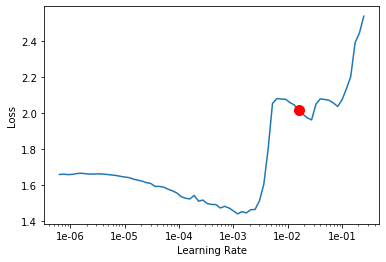

In [29]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.963885,0.936949,0.614187,02:47


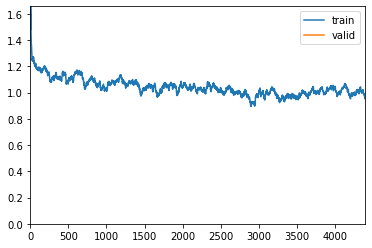

In [30]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [ ]:
# learner.save('first_cycle')

In [ ]:
# seed_all(seed)
# learner.load('first_cycle')

In [31]:
learner.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-06


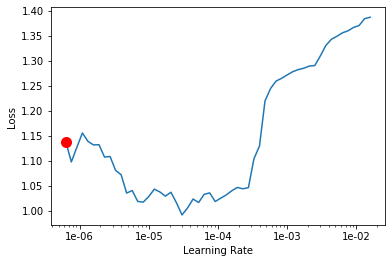

In [32]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.910501,0.885289,0.633282,08:14


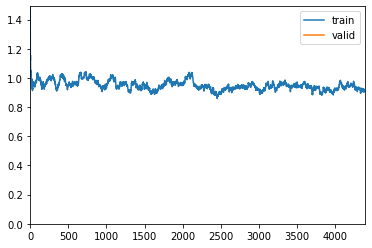

In [33]:
lr = 1e-5
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
# learner.save('second_cycle')

In [ ]:
# seed_all(seed)
# learner.load('second_cycle');

In [34]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.863546,0.843720,0.648084,12:29


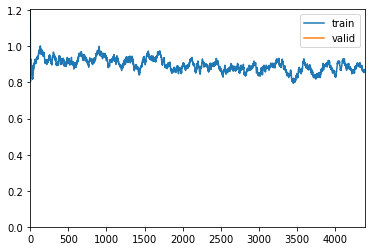

In [35]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [36]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.767322,0.758746,0.678841,47:49


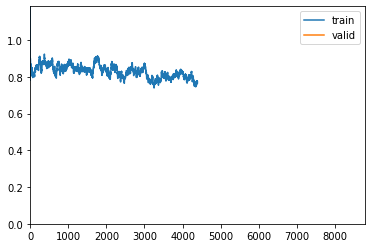

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

epoch,train_loss,valid_loss,accuracy,time
0,0.686118,0.721293,0.699603,47:10


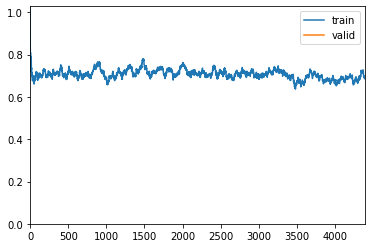

In [38]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

# Predictions

In [39]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
np.argmax(test_preds,axis=1)

In [40]:
y_pred, y_true = learner.get_preds(DatasetType.Test)

In [69]:
torch.unique(torch.argmax(y_pred, axis=-1))

tensor([0, 1, 2, 3, 4])

In [71]:
from seqeval.metrics import accuracy_score, f1_score, classification_report

t2n = lambda x: x.detach().cpu().numpy()

def f1(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    return f1_score(t2n(y_true), t2n(y_pred))

def acc(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=-1).view(-1)
    y_true = y_true.view(-1)
    return accuracy_score(t2n(y_true), t2n(y_pred))

In [75]:
# acc(y_pred, y_true)